In [30]:
#import of the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ftplib import FTP
import os
import warnings
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

In [31]:
df_hb_mod = pd.read_csv('../data/HudsonBay.csv')
df_hb_mod.head(20)

,datetime,HB_extent
0,2006-01-01,1260715.19
1,2006-01-02,1260715.19
2,2006-01-03,1260779.00
3,2006-01-04,1260779.00
4,2006-01-05,1260779.00
5,2006-01-06,1260779.00
6,2006-01-07,1260779.00
7,2006-01-08,1260779.00
8,2006-01-09,1260779.00
9,2006-01-10,1260779.00


In [32]:
df_hb_mod['date'] = pd.to_datetime(df_hb_mod['datetime'])
df_hb_mod.drop('datetime', axis=1, inplace=True)
df_hb_mod.describe()

,HB_extent
count,5.865000e+03
mean,7.466001e+05
std,5.335895e+05
min,0.000000e+00
25%,9.871402e+04
50%,1.017909e+06
75%,1.260309e+06
max,1.260903e+06


In [33]:
# first create a DataFrame with all dates between specified start<-->end using pd.date_range()
all_dates_hb = pd.DataFrame(pd.date_range(df_hb_mod['date'].min(), df_hb_mod['date'].max()), columns=['date'])

# from the all_dates DataFrame, left join onto the DataFrame with missing dates
df_hb_mod = all_dates_hb.merge(right=df_hb_mod, how='left', on='date')

# filling the NaN values with the values of the day before
df_hb_mod.fillna(method='ffill', inplace=True)
df_hb_mod = df_hb_mod.reset_index(drop=True)

df_hb_mod.tail()

,date,HB_extent
5903,2022-03-01,1260903.34
5904,2022-03-02,1260690.65
5905,2022-03-03,1260690.65
5906,2022-03-04,1260690.65
5907,2022-03-05,1260690.65


In [34]:
# split into train and test sets (we use 2019-now as test-data)

X_hb = df_hb_mod['HB_extent']
train_size_hb = int(len(X_hb)*0.8038)
train_hb, test_hb = X_hb[1:train_size_hb], X_hb[train_size_hb:]

print('Observations: %d' % (len(X_hb)))
print('Training Observations: %d' % (len(train_hb)))
print('Testing Observations: %d' % (len(test_hb)))

Observations: 5908
Training Observations: 4747
Testing Observations: 1160


In [35]:
# Extract additional features from timestamp column
df_hb_mod = df_hb_mod.assign(
    year = lambda x: x['date'].dt.year,
    month = lambda x: x['date'].dt.month,
    day = lambda x: x['date'].dt.day,
    dayofyear = lambda x: x['date'].dt.dayofyear
)
df_hb_mod.head()

,date,HB_extent,year,month,day,dayofyear
0,2006-01-01,1260715.19,2006,1,1,1
1,2006-01-02,1260715.19,2006,1,2,2
2,2006-01-03,1260779.00,2006,1,3,3
3,2006-01-04,1260779.00,2006,1,4,4
4,2006-01-05,1260779.00,2006,1,5,5


In [36]:
#dataframe for the test-split
df_hb_test = df_hb_mod.iloc[-1160:]
df_hb_test['extent_pred'] = np.nan
df_hb_test.head()

,date,HB_extent,year,month,day,dayofyear,extent_pred
4748,2019-01-01,1260903.34,2019,1,1,1,NaN
4749,2019-01-02,1260903.34,2019,1,2,2,NaN
4750,2019-01-03,1260903.34,2019,1,3,3,NaN
4751,2019-01-04,1260903.34,2019,1,4,4,NaN
4752,2019-01-05,1260903.34,2019,1,5,5,NaN


In [37]:
#dataframe for the train-split
df_hb_train = df_hb_mod.iloc[:-1160]
df_hb_train.tail()

,date,HB_extent,year,month,day,dayofyear
4743,2018-12-27,1260903.34,2018,12,27,361
4744,2018-12-28,1260903.34,2018,12,28,362
4745,2018-12-29,1260903.34,2018,12,29,363
4746,2018-12-30,1260903.34,2018,12,30,364
4747,2018-12-31,1260903.34,2018,12,31,365


In [38]:
extent_predict=df_hb_train.groupby('month')['HB_extent'].mean()
extent_predict

month
1     1.252288e+06
2     1.260545e+06
3     1.257923e+06
4     1.249250e+06
5     1.172180e+06
6     9.575249e+05
7     3.675776e+05
8     6.897391e+04
9     8.477279e+03
10    2.573372e+04
11    2.961274e+05
12    1.045404e+06
Name: HB_extent, dtype: float64

In [39]:
for months in range(1,13):
    for ind in range(4748, 4748+len(df_hb_test['month'])):
        if df_hb_test['month'][ind]==months:
           # print(ind, df_test['extent'][ind],extent_predict[months])
           #df_test['extent'][i] = extent_predict[months]
           #print(df_test['extent'][i], extent_predict[months])
            df_hb_test['extent_pred'][ind] = extent_predict[months]

df_hb_test.head()

,date,HB_extent,year,month,day,dayofyear,extent_pred
4748,2019-01-01,1260903.34,2019,1,1,1,1.252288e+06
4749,2019-01-02,1260903.34,2019,1,2,2,1.252288e+06
4750,2019-01-03,1260903.34,2019,1,3,3,1.252288e+06
4751,2019-01-04,1260903.34,2019,1,4,4,1.252288e+06
4752,2019-01-05,1260903.34,2019,1,5,5,1.252288e+06


In [40]:
#plt.rcParams.update({'figure.facecolor':'white'})
plt.style.use('seaborn-darkgrid')
#general plot settings
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('figure',figsize=(16, 9)) 
plt.rcParams['axes.labelweight'] = 'bold'



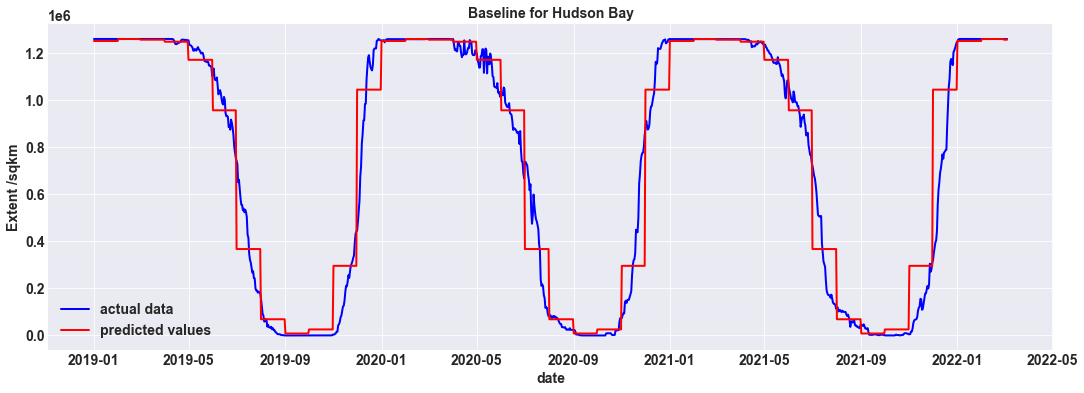

In [41]:
#plotting actual values and predicted values together
plt.figure(figsize=(18,6))
#plt.plot(df_test['timestamp'], df_test['extent'], 'b', df_obs['timestamp'], df_obs['extent'], 'r')
plt.legend(['Baseline model prediction', 'Observations'])
#plt.gca().update(dict(title='Sea ice extent on Northern hemisphere', xlabel='year', ylabel=r'10^6 sqkm'))
plt.xlabel('date')
plt.ylabel('Extent /sqkm')
plt.plot(df_hb_test['date'], df_hb_test['HB_extent'], 'b', label='actual data', linewidth=2)
plt.plot(df_hb_test['date'], df_hb_test['extent_pred'], 'r', label='predicted values', linewidth=2)
plt.legend()
plt.title('Baseline for Hudson Bay', fontdict=font)
plt.savefig('../images/Baseline_HB.png');

In [42]:
print('RMSE: ' + str(round(mean_squared_error(df_hb_test['HB_extent'], df_hb_test['extent_pred'], squared=False),3)))

RMSE: 120426.124


In [43]:
mean_absolute_error(df_hb_test['HB_extent'], df_hb_test['extent_pred'])

64549.63852507648

## monthly data for SARIMAX

In [44]:
df_ca_mod = pd.read_csv('../data/CA.csv')
df_ca_mod.head()

,date,CA_extent,SO_extent,year,month,day,dayofyear
0,2006-01-01,3225371.74,287369.54,2006,1,1,1
1,2006-01-02,3225371.74,287369.54,2006,1,2,2
2,2006-01-03,3240507.71,311943.21,2006,1,3,3
3,2006-01-04,3240326.47,372868.02,2006,1,4,4
4,2006-01-05,3240326.47,363515.34,2006,1,5,5


In [45]:
extent_month_ca=df_ca_mod.groupby(['year', 'month'])['CA_extent'].mean()
df_monthlyextent_ca = extent_month_ca.to_frame()
df_monthlyextent_ca.head()

CA_extent
year month              
2006 1      3.188713e+06
     2      3.190598e+06
     3      3.240802e+06
     4      3.185823e+06
     5      3.153358e+06

In [46]:
months = []
years = []

for i, x in enumerate(df_monthlyextent_ca['CA_extent']):
    if (i+1)%12 != 0:
        month = (i+1)%12
    else:
        month = 12
    year = 2006 + (i)//12
    months.append(month)
    years.append(year)

df_monthlyextent_ca['year'] = years
df_monthlyextent_ca['month'] = months
df_monthlyextent_ca['day'] = 1

df_monthlyextent_ca['date'] = pd.to_datetime(df_monthlyextent_ca[['year', 'month', 'day']])
df_monthlyextent_ca.head()

CA_extent  year  month  day       date
year month                                           
2006 1      3.188713e+06  2006      1    1 2006-01-01
     2      3.190598e+06  2006      2    1 2006-02-01
     3      3.240802e+06  2006      3    1 2006-03-01
     4      3.185823e+06  2006      4    1 2006-04-01
     5      3.153358e+06  2006      5    1 2006-05-01

In [130]:
df_monthlyextent_ca.reset_index(drop=True, inplace=True)
df_monthlyextent_ca.head()

,CA_extent,year,month,day,date
0,3.188713e+06,2006,1,1,2006-01-01
1,3.190598e+06,2006,2,1,2006-02-01
2,3.240802e+06,2006,3,1,2006-03-01
3,3.185823e+06,2006,4,1,2006-04-01
4,3.153358e+06,2006,5,1,2006-05-01


In [47]:
# split into train and test sets (we use the last five years as test-data)

X_monthlyextent_ca = df_monthlyextent_ca['CA_extent']

train_size_monthly_ca = int(len(X_monthlyextent_ca)*0.8038)
train_monthlyextent_ca, test_monthlyextent_ca = X_monthlyextent_ca[1:train_size_monthly_ca], X_monthlyextent_ca[train_size_monthly_ca:]
print('Observations: %d' % (len(X_monthlyextent_ca)))
print('Training Observations: %d' % (len(train_monthlyextent_ca)))
print('Testing Observations: %d' % (len(test_monthlyextent_ca)))

Observations: 195
Training Observations: 155
Testing Observations: 39


In [73]:
#SARIMA(2, 1, 2)x(2, 1, 1, 12)
mod = sm.tsa.statespace.SARIMAX(train_monthlyextent_ca,
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 9.079404
         Iterations: 15
         Function evaluations: 1642
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0866      0.234      0.370      0.711      -0.372       0.545
ar.L2         -0.0087      0.251     -0.035      0.972      -0.501       0.484
ma.L1         -0.2906      0.251     -1.159      0.247      -0.782       0.201
ma.L2         -0.0540      0.288     -0.188      0.851      -0.618       0.510
ar.S.L12       0.7412      0.103      7.170      0.000       0.539       0.944
ar.S.L24      -0.7471      0.065    -11.464      0.000      -0.875      -0.619
ma.S.L12      -0.8451      0.107     -7.890      0.000      -1.055      -0.635
ma.S.L24       0.5417      0.058      9.312      0.000       0.428       0.656
sigma2      2.513e+09   1.15e-10   2.19e+19      0.000    2.51e+09    

In [74]:
# Forecasting values
forecast_values = results.get_forecast(steps=39) 
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#fcv_series = pd.Series(forecast_values[0], index=test_month.index)

CA_extent,mean,mean_se,mean_ci_lower,mean_ci_upper
155,3.147369e+06,50124.951612,3.049126e+06,3.245612e+06
156,3.080205e+06,64064.153886,2.954641e+06,3.205768e+06
157,3.096977e+06,73421.789257,2.953073e+06,3.240881e+06
158,3.147060e+06,81601.057799,2.987125e+06,3.306996e+06
159,3.106295e+06,89037.039256,2.931786e+06,3.280805e+06
160,3.046308e+06,95899.393070,2.858349e+06,3.234267e+06
161,3.010055e+06,102302.520398,2.809546e+06,3.210565e+06
162,2.827779e+06,108327.821085,2.615460e+06,3.040097e+06
163,2.816816e+06,114035.204097,2.593311e+06,3.040321e+06
164,2.900575e+06,119470.242026,2.666418e+06,3.134732e+06


In [75]:
#evaluate the model
print('RMSE(Sarimax): ' + str(round(mean_squared_error(test_monthlyextent_ca, forecast_values.predicted_mean, squared=False),3)))

RMSE(Sarimax): 177837.853


#### sea of okhotsk

In [138]:
extent_month_so=df_ca_mod.groupby(['year', 'month'])['SO_extent'].mean()
df_monthlyextent_so = extent_month_so.to_frame()
df_monthlyextent_so.head()

SO_extent
year month               
2006 1      433881.107742
     2      754421.181786
     3      795021.644194
     4      510972.706000
     5      196972.454516

In [139]:
months = []
years = []

for i, x in enumerate(df_monthlyextent_so['SO_extent']):
    if (i+1)%12 != 0:
        month = (i+1)%12
    else:
        month = 12
    year = 2006 + (i)//12
    months.append(month)
    years.append(year)

df_monthlyextent_so['year'] = years
df_monthlyextent_so['month'] = months
df_monthlyextent_so['day'] = 1

df_monthlyextent_so['date'] = pd.to_datetime(df_monthlyextent_so[['year', 'month', 'day']])
df_monthlyextent_so.head()

SO_extent  year  month  day       date
year month                                            
2006 1      433881.107742  2006      1    1 2006-01-01
     2      754421.181786  2006      2    1 2006-02-01
     3      795021.644194  2006      3    1 2006-03-01
     4      510972.706000  2006      4    1 2006-04-01
     5      196972.454516  2006      5    1 2006-05-01

In [140]:
df_monthlyextent_so.reset_index(drop=True, inplace=True)
df_monthlyextent_so.head()

,SO_extent,year,month,day,date
0,433881.107742,2006,1,1,2006-01-01
1,754421.181786,2006,2,1,2006-02-01
2,795021.644194,2006,3,1,2006-03-01
3,510972.706000,2006,4,1,2006-04-01
4,196972.454516,2006,5,1,2006-05-01


In [145]:
df_monthlyextent_so.set_index('date', drop=False, inplace=True)
df_monthlyextent_so.head()

,SO_extent,year,month,day,date
date,,,,,
2006-01-01,433881.107742,2006,1,1,2006-01-01
2006-02-01,754421.181786,2006,2,1,2006-02-01
2006-03-01,795021.644194,2006,3,1,2006-03-01
2006-04-01,510972.706000,2006,4,1,2006-04-01
2006-05-01,196972.454516,2006,5,1,2006-05-01


In [162]:
# split into train and test sets (we use the last five years as test-data)

X_monthlyextent_so = df_monthlyextent_so['SO_extent']

train_size_monthly_so = int(len(X_monthlyextent_so)*0.8)
train_monthlyextent_so, test_monthlyextent_so = X_monthlyextent_so[1:train_size_monthly_so], X_monthlyextent_so[train_size_monthly_so:]
print('Observations: %d' % (len(X_monthlyextent_so)))
print('Training Observations: %d' % (len(train_monthlyextent_so)))
print('Testing Observations: %d' % (len(test_monthlyextent_so)))

Observations: 195
Training Observations: 155
Testing Observations: 39


In [163]:
#SARIMA(2, 1, 2)x(2, 1, 1, 12)
mod = sm.tsa.statespace.SARIMAX(train_monthlyextent_so,
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 9.413207
         Iterations: 4
         Function evaluations: 416
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6101      0.256      2.380      0.017       0.108       1.113
ar.L2         -0.2722      0.198     -1.372      0.170      -0.661       0.117
ma.L1         -0.7011      0.256     -2.743      0.006      -1.202      -0.200
ma.L2         -0.1653      0.234     -0.706      0.480      -0.624       0.293
ar.S.L12      -0.8613      0.375     -2.299      0.022      -1.596      -0.127
ar.S.L24      -0.1707      0.178     -0.962      0.336      -0.519       0.177
ma.S.L12       0.0957      0.360      0.266      0.790      -0.610       0.802
ma.S.L24      -0.2595      0.170     -1.528      0.127      -0.592       0.073
sigma2      6.131e+09   1.65e-10   3.72e+19      0.000    6.13e+09    6.

In [164]:
# Forecasting values
forecast_values = results.get_forecast(steps=39) 
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#fcv_series = pd.Series(forecast_values[0], index=test_month.index)

SO_extent,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,623791.104920,78299.078144,470327.731734,7.772545e+05
2019-02-01,941654.732723,105816.004049,734259.175799,1.149050e+06
2019-03-01,944058.414948,110715.841927,727059.352252,1.161057e+06
2019-04-01,584885.821411,111256.664155,366826.766627,8.029449e+05
2019-05-01,178247.485667,111564.120258,-40414.172006,3.969091e+05
2019-06-01,23159.813853,112265.120002,-196875.778072,2.431954e+05
2019-07-01,-5235.837757,113378.226693,-227453.078706,2.169814e+05
2019-08-01,-5637.911771,114604.218077,-230258.051679,2.189822e+05
2019-09-01,-5043.038005,115763.924957,-231936.161630,2.218501e+05
2019-10-01,-4313.164588,116848.068261,-233331.170042,2.247048e+05


In [165]:
#evaluate the model
print('RMSE(Sarimax): ' + str(round(mean_squared_error(test_monthlyextent_so, forecast_values.predicted_mean, squared=False),3)))

RMSE(Sarimax): 83006.34


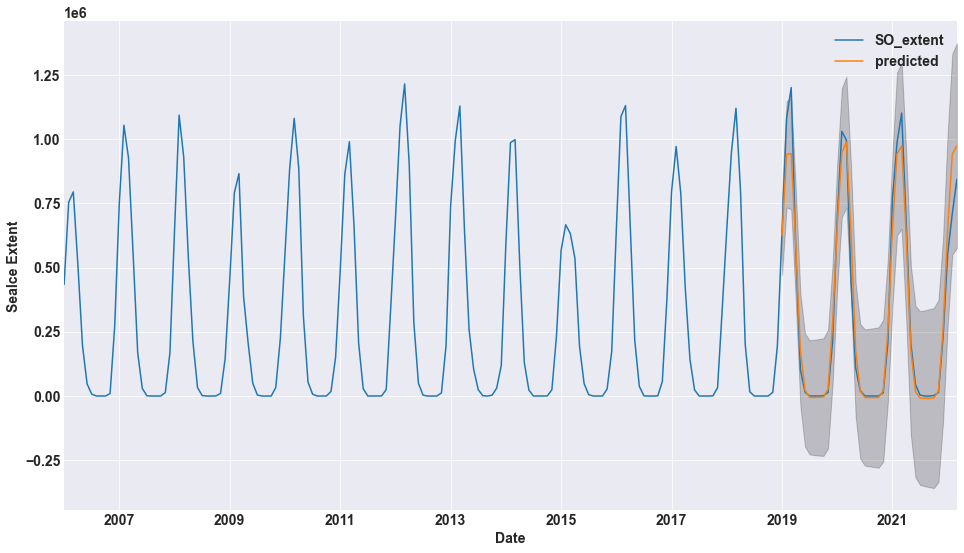

In [166]:
ax = df_monthlyextent_so.plot(x='date', y='SO_extent')
forecast_values.predicted_mean.plot(ax=ax, label='predicted')

ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('SeaIce Extent')
plt.legend()

plt.show()

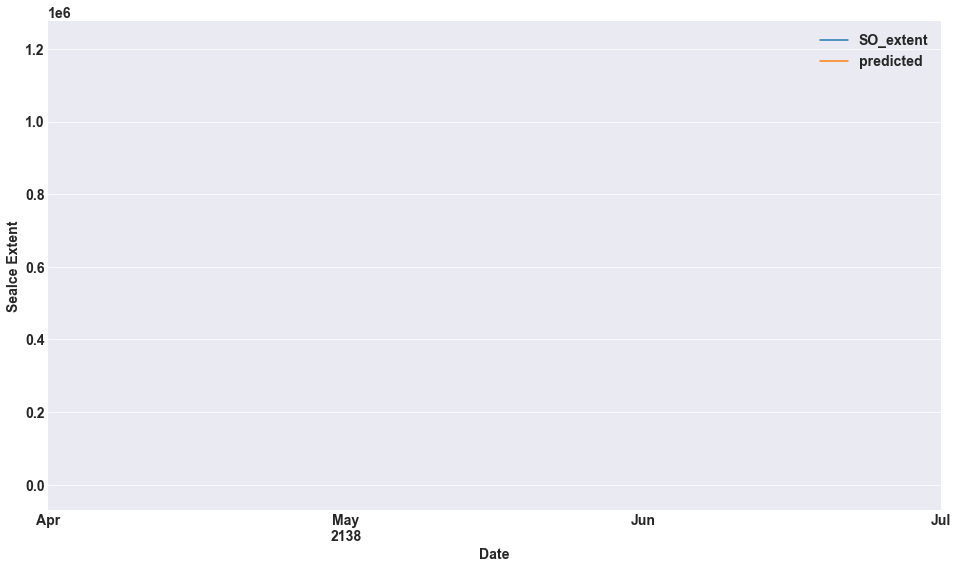

In [169]:
ax = df_monthlyextent_so.plot(x='date', y='SO_extent')
forecast_values.predicted_mean.plot(ax=ax, label='predicted')

ax.set_xlabel('Date')
ax.set_ylabel('SeaIce Extent')



plt.legend()

plt.show()

#### hudson bay

In [118]:
extent_month=df_hb_mod.groupby(['year', 'month'])['HB_extent'].mean()
extent_month

year  month
2006  1        1.260775e+06
      2        1.258036e+06
      3        1.240272e+06
      4        1.229156e+06
      5        1.073563e+06
                   ...     
2021  11       1.330682e+05
      12       8.292565e+05
2022  1        1.260426e+06
      2        1.260903e+06
      3        1.260733e+06
Name: HB_extent, Length: 195, dtype: float64

In [119]:
df_monthlyextent = extent_month.to_frame()
df_monthlyextent.head()

HB_extent
year month              
2006 1      1.260775e+06
     2      1.258036e+06
     3      1.240272e+06
     4      1.229156e+06
     5      1.073563e+06

In [120]:
df_monthlyextent.head()

HB_extent
year month              
2006 1      1.260775e+06
     2      1.258036e+06
     3      1.240272e+06
     4      1.229156e+06
     5      1.073563e+06

In [121]:
months = []
years = []

for i, x in enumerate(df_monthlyextent['HB_extent']):
    if (i+1)%12 != 0:
        month = (i+1)%12
    else:
        month = 12
    year = 2006 + (i)//12
    months.append(month)
    years.append(year)

df_monthlyextent['year'] = years
df_monthlyextent['month'] = months
df_monthlyextent['day'] = 1
df_monthlyextent.head()


HB_extent  year  month  day
year month                                
2006 1      1.260775e+06  2006      1    1
     2      1.258036e+06  2006      2    1
     3      1.240272e+06  2006      3    1
     4      1.229156e+06  2006      4    1
     5      1.073563e+06  2006      5    1

In [123]:
df_monthlyextent.reset_index(drop=True, inplace=True)
df_monthlyextent.head()

,HB_extent,year,month,day
0,1.260775e+06,2006,1,1
1,1.258036e+06,2006,2,1
2,1.240272e+06,2006,3,1
3,1.229156e+06,2006,4,1
4,1.073563e+06,2006,5,1


In [124]:
df_monthlyextent['date'] = pd.to_datetime(df_monthlyextent[['year', 'month', 'day']])
df_monthlyextent

,HB_extent,year,month,day,date
0,1.260775e+06,2006,1,1,2006-01-01
1,1.258036e+06,2006,2,1,2006-02-01
2,1.240272e+06,2006,3,1,2006-03-01
3,1.229156e+06,2006,4,1,2006-04-01
4,1.073563e+06,2006,5,1,2006-05-01
...,...,...,...,...,...
190,1.330682e+05,2021,11,1,2021-11-01
191,8.292565e+05,2021,12,1,2021-12-01
192,1.260426e+06,2022,1,1,2022-01-01
193,1.260903e+06,2022,2,1,2022-02-01


In [125]:
df_monthlyextent.set_index('date', drop=False, inplace=True)
df_monthlyextent.head()

,HB_extent,year,month,day,date
date,,,,,
2006-01-01,1.260775e+06,2006,1,1,2006-01-01
2006-02-01,1.258036e+06,2006,2,1,2006-02-01
2006-03-01,1.240272e+06,2006,3,1,2006-03-01
2006-04-01,1.229156e+06,2006,4,1,2006-04-01
2006-05-01,1.073563e+06,2006,5,1,2006-05-01


In [112]:
df_monthlyextent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 195 entries, 2006-01-01 to 2022-03-01
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   HB_extent  195 non-null    float64
 1   year       195 non-null    int64  
 2   month      195 non-null    int64  
 3   day        195 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 7.6 KB


In [113]:
# split into train and test sets (we use the last five years as test-data)

X_monthlyextent = df_monthlyextent['HB_extent']

train_size_monthly = int(len(X_monthlyextent)*0.8038)
train_monthlyextent, test_monthlyextent = X_monthlyextent[1:train_size_monthly], X_monthlyextent[train_size_monthly:]
print('Observations: %d' % (len(X_monthlyextent)))
print('Training Observations: %d' % (len(train_monthlyextent)))
print('Testing Observations: %d' % (len(test_monthlyextent)))

Observations: 195
Training Observations: 155
Testing Observations: 39


In [58]:
import statsmodels.api as sm
import matplotlib
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pylab import rcParams
import itertools

In [21]:
p = range(0, 3)
d = range(1,2)
q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod1 = sm.tsa.statespace.SARIMAX(X_monthlyextent,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod1.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
SARIMAX: (0, 1, 2) x (1, 1, 1, 12)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19663D+01    |proj g|=  7.76090D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   7.761D-07   1.197D+01
  F =   11.966348747960069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL          

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate    5    f=  1.02596D+01    |proj g|=  1.00873D-02

At iterate   10    f=  1.02594D+01    |proj g|=  2.97976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   1.644D-05   1.026D+01
  F =   10.259401236567195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:4007.1664822612056
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11660D+01    |proj g|=  4.97078D-06

           * 

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate    5    f=  1.02582D+01    |proj g|=  3.02759D-02

At iterate   10    f=  1.02572D+01    |proj g|=  2.61972D-02

At iterate   15    f=  1.02395D+01    |proj g|=  5.93308D-01

At iterate   20    f=  1.02246D+01    |proj g|=  3.84082D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   4.478D-05   1.022D+01
  F =   10.224557488165498     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:3995.577420384544
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:4045.161573312005
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03359D+01    |proj g|=  8.89015D-02

At iterate    5    f=  1.03127D+01    |proj g|=  4.34495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     12      1     0     0   1.525D-06   1.031D+01
  F =   10.312674168069066     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:4029.9429255469354
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04003D+01    |proj g|=  1.58759D+00


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02497D+01    |proj g|=  1.49574D-02

At iterate   10    f=  1.02494D+01    |proj g|=  2.28775D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   2.288D-04   1.025D+01
  F =   10.249358855650403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:4007.2499537036574
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18564D+01    |proj g|=  1.20101D-01

At iterate   

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate    5    f=  1.01794D+01    |proj g|=  3.76282D-02

At iterate   10    f=  1.01692D+01    |proj g|=  8.04341D-03

At iterate   15    f=  1.01692D+01    |proj g|=  3.36323D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   3.219D-06   1.017D+01
  F =   10.169217937346854     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 1, 2, 12)12 - AIC:3973.9949955652733
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi

ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:4283.793267134684
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05756D+01    |proj g|=  3.64790D+00


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01750D+01    |proj g|=  6.68869D-02

At iterate   10    f=  1.01726D+01    |proj g|=  1.21371D-02

At iterate   15    f=  1.01690D+01    |proj g|=  1.81282D-01

At iterate   20    f=  1.01611D+01    |proj g|=  8.62446D-02

At iterate   25    f=  1.01605D+01    |proj g|=  4.18963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     36      1     0     0   2.520D-06   1.016D+01
  F =   10.160533753347050     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 2, 12)12 - AIC:3972.6081638053492
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:4028.433534911399
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03202D+01    |proj g|=  6.95658D-02

At iterate    5    f=  1.02924D+01    |proj g|=  1.00027D-02

At iterate   10    f=  1.02923D+01    |proj g|=  4.92566D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   4.926D-06   1.029D+01
  F =   10.292288322273626     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:4023.992445686714
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03531D+01    |proj g|=  1.67385D+00


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01727D+01    |proj g|=  7.45068D-02

At iterate   10    f=  1.01665D+01    |proj g|=  9.41619D-03

At iterate   15    f=  1.01661D+01    |proj g|=  8.00964D-03

At iterate   20    f=  1.01579D+01    |proj g|=  1.12131D-01

At iterate   25    f=  1.01515D+01    |proj g|=  1.36390D-02

At iterate   30    f=  1.01514D+01    |proj g|=  1.63720D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     54      1     0     0   1.637D-05   1.015D+01
  F =   10.151384768024965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:3971.040059529

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16723D+01    |proj g|=  1.92507D+01

At iterate    5    f=  1.01396D+01    |proj g|=  2.51248D-01


 This problem is unconstrained.



At iterate   10    f=  1.00544D+01    |proj g|=  1.26684D-01

At iterate   15    f=  1.00421D+01    |proj g|=  7.39689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     22      1     0     0   2.214D-06   1.004D+01
  F =   10.042116964978231     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:3926.4256163415102
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10704D+01    |proj g|=  1.07184D+00

At iterate   

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi

At iterate    5    f=  1.08345D+01    |proj g|=  2.60082D-03

At iterate   10    f=  1.08345D+01    |proj g|=  9.55263D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     18      1     0     0   1.020D-05   1.083D+01
  F =   10.834457454099399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 1, 1, 12)12 - AIC:4235.438407098765
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12859D+01    |proj g|=  1.37611D+01


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00665D+01    |proj g|=  2.47083D-01

At iterate   10    f=  1.00458D+01    |proj g|=  1.27835D-02

At iterate   15    f=  1.00448D+01    |proj g|=  1.39546D-02

At iterate   20    f=  1.00393D+01    |proj g|=  5.51186D-02

At iterate   25    f=  1.00375D+01    |proj g|=  1.94792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     43      1     0     0   2.296D-05   1.004D+01
  F =   10.037544187624391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:3926.6422331735125
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:4004.832419767871
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02752D+01    |proj g|=  1.39910D+00

At iterate    5    f=  1.02283D+01    |proj g|=  1.95605D-02


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.02264D+01    |proj g|=  8.29397D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     15      1     0     0   2.206D-05   1.023D+01
  F =   10.226415357047120     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:4000.3019892483767
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06813D+01    |proj g|=  8.19444D+00


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00587D+01    |proj g|=  1.61694D-01

At iterate   10    f=  1.00383D+01    |proj g|=  4.18126D-03

At iterate   15    f=  1.00378D+01    |proj g|=  1.07719D-02

At iterate   20    f=  1.00335D+01    |proj g|=  2.89255D-02

At iterate   25    f=  1.00321D+01    |proj g|=  1.19052D-02

At iterate   30    f=  1.00319D+01    |proj g|=  2.67059D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     41      1     0     0   2.681D-05   1.003D+01
  F =   10.031913349896906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:3926.446206459

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate    5    f=  1.02637D+01    |proj g|=  2.29713D-02

At iterate   10    f=  1.02633D+01    |proj g|=  5.58543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   1.808D-05   1.026D+01
  F =   10.263263481673718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:4010.6727578527502
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10979D+01    |proj g|=  1.32350D-02

           * 

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate    5    f=  1.02675D+01    |proj g|=  2.40871D-02

At iterate   10    f=  1.02668D+01    |proj g|=  1.35819D-02

At iterate   15    f=  1.02569D+01    |proj g|=  4.57975D-01

At iterate   20    f=  1.02434D+01    |proj g|=  1.55029D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     34      1     0     0   2.173D-05   1.024D+01
  F =   10.243213964067584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 2, 12)12 - AIC:4004.8534459863577
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:4022.6619376103163
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02788D+01    |proj g|=  5.93094D-02

At iterate    5    f=  1.02598D+01    |proj g|=  1.04327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   3.007D-05   1.026D+01
  F =   10.259799183319224     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(1, 1, 0)x(2, 1, 1, 12)12 - AIC:4011.321681494497
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03949D+01    |proj g|=  1.34402D+00


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02615D+01    |proj g|=  1.23659D-02

At iterate   10    f=  1.02613D+01    |proj g|=  2.49256D-04

At iterate   15    f=  1.02613D+01    |proj g|=  1.97225D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     22      1     0     0   9.111D-05   1.026D+01
  F =   10.261257554138584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(2, 1, 2, 12)12 - AIC:4013.8904461140482
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate   15    f=  1.09280D+01    |proj g|=  2.12044D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     26      1     0     0   2.120D-06   1.093D+01
  F =   10.927952884074024     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:4269.901624788869
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50501D+01    |proj g|=  1.89337D+02

At iterate    5    f=  1.05147D+01    |proj g|=  3.07060D-01


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.04330D+01    |proj g|=  2.85255D-01

At iterate   15    f=  1.02596D+01    |proj g|=  5.13451D-01

At iterate   20    f=  1.01934D+01    |proj g|=  8.40345D-02

At iterate   25    f=  1.01931D+01    |proj g|=  2.59658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     43      1     0     0   1.264D-05   1.019D+01
  F =   10.193088970431953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 1, 2, 12)12 - AIC:3985.304698468462
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate    5    f=  1.10631D+01    |proj g|=  9.29102D-02

At iterate   10    f=  1.10498D+01    |proj g|=  3.11852D-03

At iterate   15    f=  1.10497D+01    |proj g|=  1.30409D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     25      1     0     0   7.203D-06   1.105D+01
  F =   11.049727785473163     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:4319.393836334533
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.05033D+01    |proj g|=  3.11459D-01

At iterate   10    f=  1.03378D+01    |proj g|=  2.01703D-01

At iterate   15    f=  1.02181D+01    |proj g|=  3.15526D-01

At iterate   20    f=  1.02013D+01    |proj g|=  9.38969D-03

At iterate   25    f=  1.01806D+01    |proj g|=  3.13913D-01

At iterate   30    f=  1.01679D+01    |proj g|=  1.86551D-02

At iterate   35    f=  1.01679D+01    |proj g|=  2.69319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     57      1     0     0   1.333D-05   1.017D+01
  F =   10.167858001513467     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02040D+01    |proj g|=  9.65302D-03

At iterate   10    f=  1.02039D+01    |proj g|=  9.51719D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     24      1     0     0   6.570D-06   1.020D+01
  F =   10.203915961694552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:3989.527225060875
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.00529D+01    |proj g|=  3.86804D+02


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02697D+01    |proj g|=  2.74056D-01

At iterate   10    f=  1.02651D+01    |proj g|=  8.30555D-02

At iterate   15    f=  1.02620D+01    |proj g|=  3.95392D-02

At iterate   20    f=  1.02620D+01    |proj g|=  9.27104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     36      1     0     0   1.585D-04   1.026D+01
  F =   10.261990637519457     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 1, 12)12 - AIC:4014.176348632588
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02982D+01    |proj g|=  3.38803D-01

At iterate   10    f=  1.01840D+01    |proj g|=  2.44747D-01

At iterate   15    f=  1.01506D+01    |proj g|=  1.14689D-01

At iterate   20    f=  1.01288D+01    |proj g|=  3.05742D-02

At iterate   25    f=  1.01260D+01    |proj g|=  3.52605D-03

At iterate   30    f=  1.01260D+01    |proj g|=  4.12809D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     48      1     0     0   1.982D-05   1.013D+01
  F =   10.125975412725753     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(2, 1, 2, 12)12 - AIC:3963.130410963

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi

    5     14     18      1     0     0   1.367D-05   1.084D+01
  F =   10.837670424331550     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 1, 12)12 - AIC:4236.691465489304
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50366D+01    |proj g|=  1.26017D+02


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01756D+01    |proj g|=  3.22215D-01

At iterate   10    f=  1.00488D+01    |proj g|=  3.80041D-02

At iterate   15    f=  1.00419D+01    |proj g|=  3.75895D-02

At iterate   20    f=  1.00418D+01    |proj g|=  1.96293D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   2.734D-05   1.004D+01
  F =   10.041766205659528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(0, 1, 2, 12)12 - AIC:3928.288820207216
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate    5    f=  1.08471D+01    |proj g|=  1.02233D-01

At iterate   10    f=  1.08350D+01    |proj g|=  2.85844D-02

At iterate   15    f=  1.08340D+01    |proj g|=  5.09545D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     21      1     0     0   1.361D-05   1.083D+01
  F =   10.834039539572830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(1, 1, 1, 12)12 - AIC:4237.275420433403


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37783D+01    |proj g|=  1.00028D+02

At iterate    5    f=  1.00504D+01    |proj g|=  5.91854D-02

At iterate   10    f=  1.00472D+01    |proj g|=  2.82732D-02

At iterate   15    f=  1.00446D+01    |proj g|=  6.30937D-03

At iterate   20    f=  1.00408D+01    |proj g|=  6.82890D-02

At iterate   25    f=  1.00368D+01    |proj g|=  8.84728D-03

At iterate   30    f=  1.00368D+01    |proj g|=  2.32454D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01804D+01    |proj g|=  1.26725D-02

At iterate   10    f=  1.01801D+01    |proj g|=  1.60806D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     22      1     0     0   6.181D-05   1.018D+01
  F =   10.179962697090426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:3982.1854518652663
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05427D+01    |proj g|=  1.62684D+01

At iterate   

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.01646D+01    |proj g|=  2.39835D-02

At iterate   15    f=  1.01633D+01    |proj g|=  5.99636D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     19      1     0     0   3.454D-05   1.016D+01
  F =   10.163270217202014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:3977.6753847087853
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22583D+01    |proj g|=  6.61983D+01


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00449D+01    |proj g|=  7.55605D-02

At iterate   10    f=  1.00405D+01    |proj g|=  1.94931D-02

At iterate   15    f=  1.00375D+01    |proj g|=  2.62481D-03

At iterate   20    f=  1.00375D+01    |proj g|=  3.92688D-03

At iterate   25    f=  1.00331D+01    |proj g|=  4.28250D-02

At iterate   30    f=  1.00315D+01    |proj g|=  1.98931D-02

At iterate   35    f=  1.00314D+01    |proj g|=  1.48375D-03

At iterate   40    f=  1.00313D+01    |proj g|=  2.15516D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     55      1     0     0   3.778D-05   1.003D+01
  F =   10.0313368738

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate    5    f=  1.02113D+01    |proj g|=  2.08081D-02

At iterate   10    f=  1.02109D+01    |proj g|=  1.57130D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   1.829D-05   1.021D+01
  F =   10.210929632364534     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:3992.2625566221686
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09728D+01    |proj g|=  2.11108D-02

           * 

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06705D+01    |proj g|=  4.15937D+00


 This problem is unconstrained.



At iterate    5    f=  1.02156D+01    |proj g|=  4.92476D-02

At iterate   10    f=  1.02147D+01    |proj g|=  6.09784D-03

At iterate   15    f=  1.02037D+01    |proj g|=  3.25623D-01

At iterate   20    f=  1.01944D+01    |proj g|=  1.07944D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     32      1     0     0   4.721D-05   1.019D+01
  F =   10.194324362430859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:3987.786501348035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:3977.274224650714
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01582D+01    |proj g|=  6.08513D-02

At iterate    5    f=  1.01435D+01    |proj g|=  2.95034D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      8     10      1     0     0   4.039D-06   1.014D+01
  F =   10.143492744636710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(2, 1, 0)x(2, 1, 1, 12)12 - AIC:3967.962170408317
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03515D+01    |proj g|=  1.92025D+00


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01450D+01    |proj g|=  1.52673D-02

At iterate   10    f=  1.01448D+01    |proj g|=  5.83283D-04

At iterate   15    f=  1.01448D+01    |proj g|=  4.23966D-03

At iterate   20    f=  1.01447D+01    |proj g|=  6.60076D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     26      1     0     0   6.601D-06   1.014D+01
  F =   10.144735883193006     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 0)x(2, 1, 2, 12)12 - AIC:3970.446994445272
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10593D+01    |proj g|=  1.18964D+01

At iterate    5    f=  1.01652D+01    |proj g|=  2.45119D-01


 This problem is unconstrained.



At iterate   10    f=  1.01050D+01    |proj g|=  1.03452D-01

At iterate   15    f=  1.00941D+01    |proj g|=  4.76504D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     21      1     0     0   3.545D-06   1.009D+01
  F =   10.094134916612791     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:3948.7126174789887
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09091D+01    |proj g|=  6.86656D-02

At iterate   

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate   10    f=  1.08855D+01    |proj g|=  3.22038D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     17      1     0     0   4.546D-05   1.089D+01
  F =   10.885484439850343     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:4257.338931541633
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08436D+01    |proj g|=  6.30605D+00


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01063D+01    |proj g|=  6.27484D-02

At iterate   10    f=  1.01000D+01    |proj g|=  1.09545D-02

At iterate   15    f=  1.00886D+01    |proj g|=  8.21971D-02

At iterate   20    f=  1.00882D+01    |proj g|=  8.68825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     31      1     0     0   1.409D-05   1.009D+01
  F =   10.088198579768596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:3948.3974461097528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:3953.006791175939
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    0    f=  1.01012D+01    |proj g|=  1.44035D-01

At iterate    5    f=  1.00903D+01    |proj g|=  1.04752D-02

At iterate   10    f=  1.00899D+01    |proj g|=  1.82945D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     14      1     0     0   1.034D-05   1.009D+01
  F =   10.089923376126432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:3949.0701166893086
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00939D+01    |proj g|=  3.29219D-02

At iterate   10    f=  1.00907D+01    |proj g|=  3.15535D-03

At iterate   15    f=  1.00884D+01    |proj g|=  9.85782D-02

At iterate   20    f=  1.00850D+01    |proj g|=  8.92386D-02

At iterate   25    f=  1.00842D+01    |proj g|=  4.05185D-03

At iterate   30    f=  1.00842D+01    |proj g|=  1.44378D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     31     46      1     0     0   7.989D-05   1.008D+01
  F =   10.084205986950849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:3948.840334910

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 Thi


At iterate   15    f=  1.08192D+01    |proj g|=  2.46024D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     20      1     0     0   1.256D-04   1.082D+01
  F =   10.819218720953405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:4231.495301171828
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10810D+01    |proj g|=  1.28933D+01


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01276D+01    |proj g|=  2.59813D-01

At iterate   10    f=  1.00317D+01    |proj g|=  3.62204D-02

At iterate   15    f=  1.00269D+01    |proj g|=  3.28485D-02

At iterate   20    f=  1.00223D+01    |proj g|=  1.25368D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     29      1     0     0   1.006D-04   1.002D+01
  F =   10.022267138948390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:3922.684184189872
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  1.08936D+01    |proj g|=  4.90612D-03

At iterate   20    f=  1.08936D+01    |proj g|=  5.62839D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     30      1     0     0   5.628D-06   1.089D+01
  F =   10.893592411156460     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:4260.50104035102
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08904D+01    |proj g|=  1.05378D+00

At iterate    5

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.08191D+01    |proj g|=  4.85858D-02

At iterate   15    f=  1.08146D+01    |proj g|=  1.01546D-02

At iterate   20    f=  1.08144D+01    |proj g|=  2.82625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     27      1     0     0   2.106D-05   1.081D+01
  F =   10.814418805118580     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:4231.623333996246


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08812D+01    |proj g|=  7.09250D+00

At iterate    5    f=  1.00459D+01    |proj g|=  7.07252D-02

At iterate   10    f=  1.00361D+01    |proj g|=  1.41549D-02

At iterate   15    f=  1.00213D+01    |proj g|=  4.45498D-01

At iterate   20    f=  1.00105D+01    |proj g|=  1.72811D-02

At iterate   25    f=  1.00095D+01    |proj g|=  3.83477D-02

At iterate   30    f=  1.00086D+01    |proj g|=  1.21098D-02

At iterate   35    f=  1.00084D+01    |proj g|=  3.12156D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.00982D+01    |proj g|=  4.28020D-02

At iterate   15    f=  1.00969D+01    |proj g|=  8.72347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     23      1     0     0   3.830D-06   1.010D+01
  F =   10.096918314348894     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:3951.798142596069
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00995D+01    |proj g|=  2.31522D-01


/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00881D+01    |proj g|=  2.83756D-02

At iterate   10    f=  1.00850D+01    |proj g|=  2.20475D-02

At iterate   15    f=  1.00831D+01    |proj g|=  1.10583D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     18     21      1     0     0   1.075D-05   1.008D+01
  F =   10.083051895790842     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:3948.3902393584285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kaddy/Documents/neue_fische/ice_cream/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00283D+01    |proj g|=  3.08532D-02

At iterate   10    f=  1.00243D+01    |proj g|=  3.06521D-02

At iterate   15    f=  1.00204D+01    |proj g|=  5.09960D-03

At iterate   20    f=  1.00201D+01    |proj g|=  6.58024D-03

At iterate   25    f=  1.00140D+01    |proj g|=  6.42277D-02

At iterate   30    f=  1.00071D+01    |proj g|=  4.39799D-02

At iterate   35    f=  1.00032D+01    |proj g|=  4.29049D-02

At iterate   40    f=  1.00024D+01    |proj g|=  1.81882D-03

At iterate   45    f=  1.00024D+01    |proj g|=  1.41738D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     46     64   

In [114]:
#SARIMA(2, 1, 2)x(2, 1, 2, 12)
mod = sm.tsa.statespace.SARIMAX(train_monthlyextent,
                                order=(2, 1, 2),
                                seasonal_order=(2, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
#fit the model
results = mod.fit(method = 'powell')
print(results.summary().tables[1])

Optimization terminated successfully.
         Current function value: 9.353826
         Iterations: 7
         Function evaluations: 735
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6151      0.293      2.102      0.036       0.042       1.189
ar.L2         -0.4773      0.132     -3.615      0.000      -0.736      -0.219
ma.L1         -1.0316      0.340     -3.032      0.002      -1.698      -0.365
ma.L2          0.3144      0.295      1.066      0.287      -0.264       0.893
ar.S.L12      -0.4289      0.159     -2.694      0.007      -0.741      -0.117
ar.S.L24      -0.3570      0.093     -3.826      0.000      -0.540      -0.174
ma.S.L12      -0.0429      0.127     -0.338      0.735      -0.292       0.206
ma.S.L24      -0.0570      0.074     -0.767      0.443      -0.203       0.089
sigma2      5.199e+09   3.37e-11   1.54e+20      0.000     5.2e+09     5

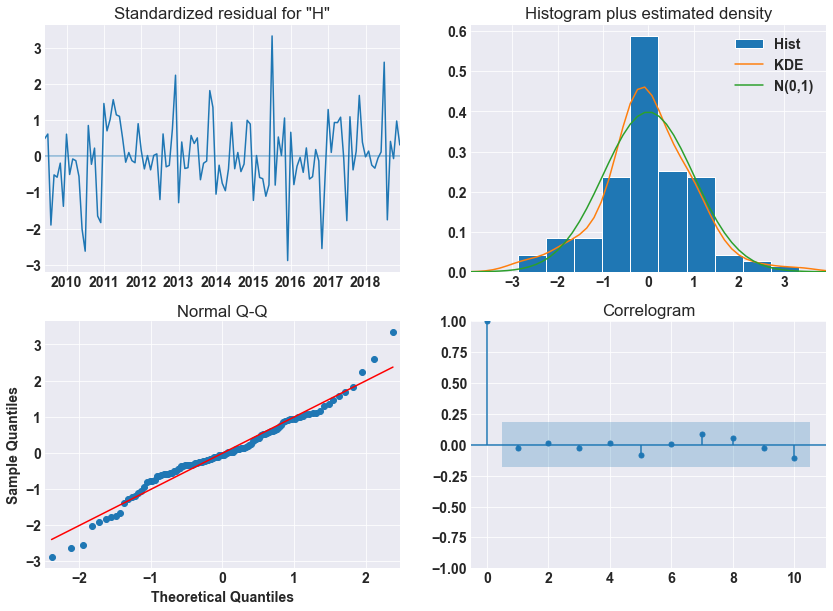

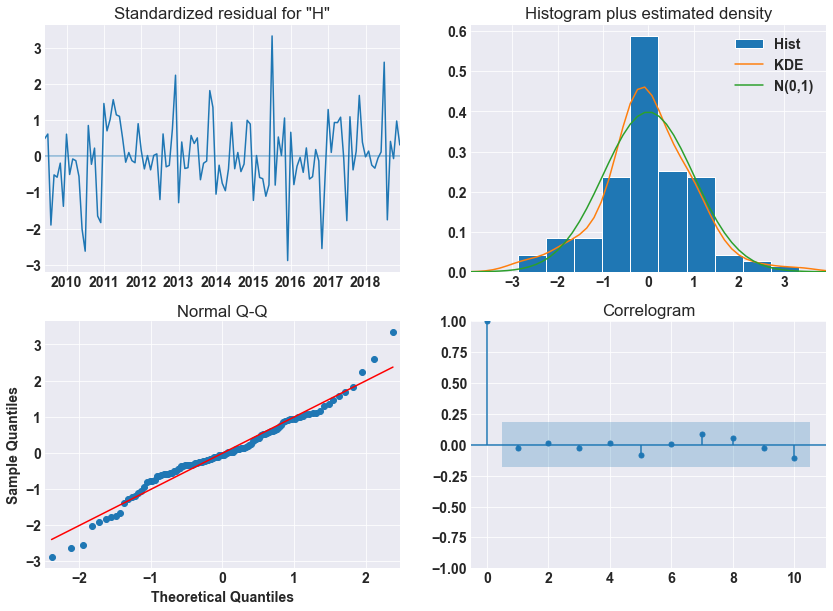

In [115]:
results.plot_diagnostics(figsize=(14,10))

In [116]:
# Forecasting values
forecast_values = results.get_forecast(steps=39) 
forecast_ci = forecast_values.conf_int()
forecast_values.summary_frame()
#fcv_series = pd.Series(forecast_values[0], index=test_month.index)

HB_extent,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-01-01,1.329520e+06,72105.497064,1.188196e+06,1.470844e+06
2019-02-01,1.306537e+06,83482.858428,1.142914e+06,1.470161e+06
2019-03-01,1.316535e+06,84320.149978,1.151271e+06,1.481800e+06
2019-04-01,1.330364e+06,84661.979891,1.164430e+06,1.496299e+06
2019-05-01,1.267915e+06,86858.258037,1.097676e+06,1.438154e+06
2019-06-01,1.076515e+06,91477.738538,8.972222e+05,1.255808e+06
2019-07-01,5.806566e+05,95898.765644,3.926984e+05,7.686147e+05
2019-08-01,1.377599e+05,98952.959702,-5.618431e+04,3.317042e+05
2019-09-01,7.661138e+04,101295.542946,-1.219242e+05,2.751470e+05
2019-10-01,1.096007e+05,103671.859056,-9.359238e+04,3.127938e+05


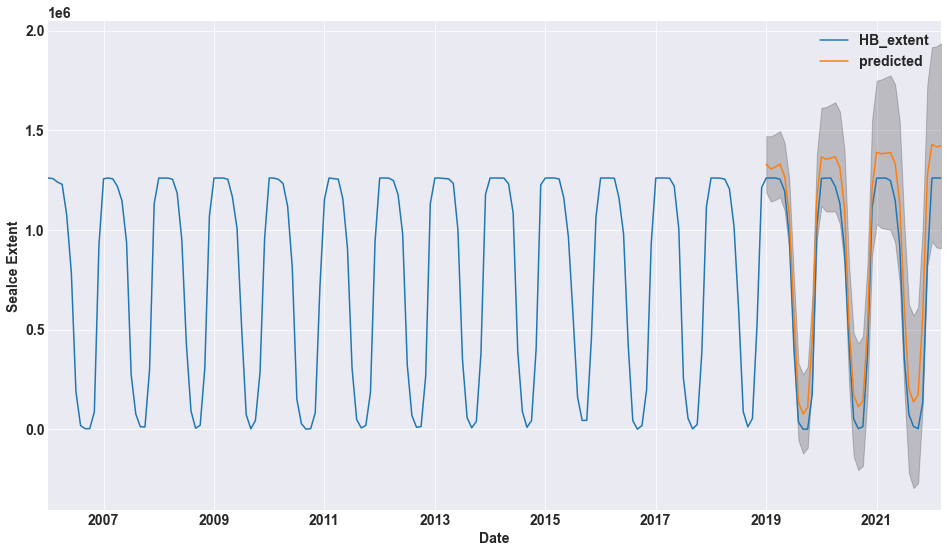

In [127]:
ax = df_monthlyextent.plot(x='date', y='HB_extent')
forecast_values.predicted_mean.plot(ax=ax, label='predicted')

ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:, 0],
                forecast_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('SeaIce Extent')
plt.legend()

plt.show()

In [128]:
#evaluate the model
print('RMSE(Sarimax): ' + str(round(mean_squared_error(test_monthlyextent, forecast_values.predicted_mean, squared=False),3)))

RMSE(Sarimax): 170810.352
